# Analyzing Audits

**Predicting Cell Health**

**Gregory Way, 2019**

Detecting replicate correlation across treatments, wells, and cell lines.

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import plotnine as gg

In [2]:
%matplotlib inline

In [3]:
# Load Audits
# (both detailed treatments and null threshold summaries)
data_dir = "data"

audit_df_list = []
audit_summary_list = []
for file in os.listdir(data_dir):
    full_file = os.path.join(data_dir, file)
    df = pd.read_csv(full_file)
    if 'detailed' in file:
        audit_df_list.append(df)
    if 'audit.csv' in file:
        audit_summary_list.append(df)
        
audit_df = pd.concat(audit_df_list)
summary_audit_df = pd.concat(audit_summary_list).reset_index(drop=True)

print(audit_df.shape)
audit_df.head()

(984, 12)


,Metadata_Plate_Map_Name,Metadata_Well,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_cell_id,Metadata_broad_sample_type,Metadata_pert_type,correlation
0,DEPENDENCIES1_ES2,A02,MCL1,MCL1-5,NaN,ES2,NaN,NaN,unknown,trt,trt,0.318465
1,DEPENDENCIES1_ES2,A03,AKT1,AKT1-1,BRDN0001054908,ES2,NaN,BRDN0001054908,unknown,trt,trt,0.393790
2,DEPENDENCIES1_ES2,A04,KRAS,KRAS-2B,NaN,ES2,NaN,NaN,unknown,trt,trt,0.003918
3,DEPENDENCIES1_ES2,A05,AKT1,AKT1-2,BRDN0001055115,ES2,NaN,BRDN0001055115,unknown,trt,trt,0.237607
4,DEPENDENCIES1_ES2,A07,BRAF1,BRAF1-1,BRDN0000986682,ES2,NaN,BRDN0000986682,unknown,trt,trt,0.423025


## Interpretation of `correlation`

This represents the median pairwise Pearson correlation of replicates across genes, perturbations, and cell lines.
The data here represent correlations across cell painting profiles.

In [4]:
# Process the summary audits
summary_audit_df = (
    pd.concat(
        [summary_audit_df,
         summary_audit_df.plate_map_name.str.split('_', expand=True).iloc[:, 1]],
        axis='columns'
    )
    .rename(columns={1: 'Metadata_cell_line'})
)

summary_audit_df

,plate_map_name,null_threshold,fraction_strong,Metadata_cell_line
0,DEPENDENCIES1_HCC44,0.356182,0.491525,HCC44
1,DEPENDENCIES1_ES2,0.435187,0.506098,ES2
2,DEPENDENCIES1_A549,0.700114,0.341463,A549


## Interpretation of `null_threshold`

The `null_threshold` column above is generated in [broadinstitute/cytominer_scripts/audit.R](https://github.com/broadinstitute/cytominer_scripts/blob/master/audit.R).

The metric represents a random sampling of different samples and combined, over many iterations, to represent a null distribution of correlation.

In [5]:
# Summarize the audits using median correlation per gene and cell line
median_collapsed_correlation_df = (
    audit_df
    .groupby(['Metadata_gene_name', 'Metadata_pert_name', 'Metadata_cell_line'])
    ['correlation']
    .median()
    .reset_index()
    .groupby(['Metadata_gene_name', 'Metadata_cell_line'])
    ['correlation']
    .median()
    .reset_index()
    .rename(columns={'correlation': 'median_correlation'})
)

median_collapsed_correlation_df.head()

,Metadata_gene_name,Metadata_cell_line,median_correlation
0,AKT1,A549,0.392012
1,AKT1,ES2,0.214421
2,AKT1,HCC44,0.521952
3,ARID1B,A549,0.575147
4,ARID1B,ES2,0.326936


## Interpretation of `median_correlation`

This value represents the median correlation across all **guides** targetting the given gene for the given cell line.

Therefore, the `median_correlation` is a median (guides) of medians (replicates of single guides) of medians (profiles of individual cells in a single well).

In [6]:
# Merge summarized data into audit dataframe
merge_cols = ['Metadata_gene_name', 'Metadata_cell_line']

audit_df = (
    audit_df
    .merge(
        median_collapsed_correlation_df,
        left_on=merge_cols,
        right_on=merge_cols
    )
)

# Determine how many CRISPRs are targetting the gene
audit_df = (
    audit_df
    .assign(
        guide_index=(
            audit_df
            .groupby(merge_cols)
            .cumcount()+1
        )
        .tolist()
    )
    .query("Metadata_gene_name != 'Chr2'")
    .sort_values(by='median_correlation',
                 ascending=False)
)

audit_df.guide_index = audit_df.guide_index.astype('str')
audit_df.head()

,Metadata_Plate_Map_Name,Metadata_Well,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_cell_id,Metadata_broad_sample_type,Metadata_pert_type,correlation,median_correlation,guide_index
539,DEPENDENCIES1_HCC44,C21,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,trt,0.901707,0.931138,2
538,DEPENDENCIES1_HCC44,C19,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,trt,0.935242,0.931138,1
540,DEPENDENCIES1_HCC44,M04,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,trt,0.945647,0.931138,3
541,DEPENDENCIES1_HCC44,M06,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,trt,0.941955,0.931138,4
450,DEPENDENCIES1_HCC44,J10,POLR2D,POLR2D-2,NaN,HCC44,NaN,NaN,unknown,trt,trt,0.937823,0.918707,9


In [7]:
# Get audit_df ready to plot
gene_name_cat = pd.CategoricalDtype(categories=audit_df.Metadata_gene_name.unique().tolist())
audit_df = audit_df.assign(
    gene_plot_id=audit_df.Metadata_gene_name.astype(str).astype(gene_name_cat)
)

# Merge with the summary to add in cell line specific lines
audit_df = (
    audit_df
    .merge(summary_audit_df,
           left_on='Metadata_cell_line',
           right_on='Metadata_cell_line')
)

audit_df.head()

,Metadata_Plate_Map_Name,Metadata_Well,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_cell_id,Metadata_broad_sample_type,Metadata_pert_type,correlation,median_correlation,guide_index,gene_plot_id,plate_map_name,null_threshold,fraction_strong
0,DEPENDENCIES1_HCC44,C21,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,trt,0.901707,0.931138,2,ITGAV,DEPENDENCIES1_HCC44,0.356182,0.491525
1,DEPENDENCIES1_HCC44,C19,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,trt,0.935242,0.931138,1,ITGAV,DEPENDENCIES1_HCC44,0.356182,0.491525
2,DEPENDENCIES1_HCC44,M04,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,trt,0.945647,0.931138,3,ITGAV,DEPENDENCIES1_HCC44,0.356182,0.491525
3,DEPENDENCIES1_HCC44,M06,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,trt,0.941955,0.931138,4,ITGAV,DEPENDENCIES1_HCC44,0.356182,0.491525
4,DEPENDENCIES1_HCC44,J10,POLR2D,POLR2D-2,NaN,HCC44,NaN,NaN,unknown,trt,trt,0.937823,0.918707,9,POLR2D,DEPENDENCIES1_HCC44,0.356182,0.491525


In [8]:
audit_df.head()

,Metadata_Plate_Map_Name,Metadata_Well,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_cell_id,Metadata_broad_sample_type,Metadata_pert_type,correlation,median_correlation,guide_index,gene_plot_id,plate_map_name,null_threshold,fraction_strong
0,DEPENDENCIES1_HCC44,C21,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,trt,0.901707,0.931138,2,ITGAV,DEPENDENCIES1_HCC44,0.356182,0.491525
1,DEPENDENCIES1_HCC44,C19,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,trt,0.935242,0.931138,1,ITGAV,DEPENDENCIES1_HCC44,0.356182,0.491525
2,DEPENDENCIES1_HCC44,M04,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,trt,0.945647,0.931138,3,ITGAV,DEPENDENCIES1_HCC44,0.356182,0.491525
3,DEPENDENCIES1_HCC44,M06,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,trt,0.941955,0.931138,4,ITGAV,DEPENDENCIES1_HCC44,0.356182,0.491525
4,DEPENDENCIES1_HCC44,J10,POLR2D,POLR2D-2,NaN,HCC44,NaN,NaN,unknown,trt,trt,0.937823,0.918707,9,POLR2D,DEPENDENCIES1_HCC44,0.356182,0.491525


## Plot Figures

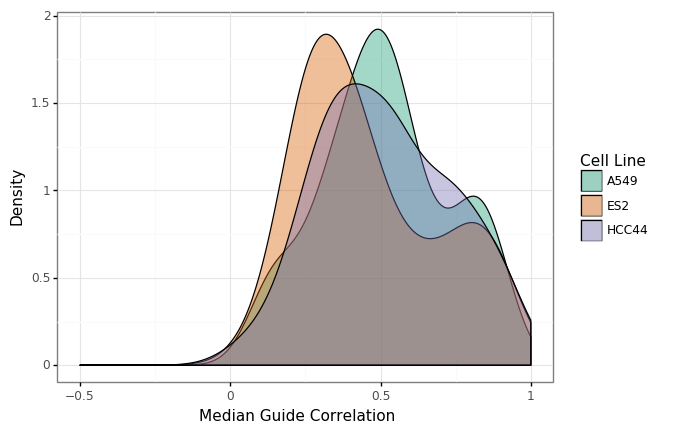

<ggplot: (-9223372036556418686)>

In [9]:
gg.options.figure_size=(6.4, 4.8)

# Make sure to drop duplicates of redundant gene, perturbation, and cell line columns
# Not removing replicates will put more weight on genes with more measurements

cor_density_gg = (
    gg.ggplot(audit_df.drop_duplicates(["Metadata_gene_name", "Metadata_pert_name", "Metadata_cell_line"]),
              gg.aes(x="median_correlation")) + \
        gg.geom_density(gg.aes(fill="Metadata_cell_line"),
                        alpha=0.4) + \
        gg.theme_bw() + \
        gg.xlim([-0.5, 1]) + \
        gg.xlab("Median Guide Correlation") + \
        gg.ylab("Density") + \
        gg.scale_fill_manual(name="Cell Line",
                             values=["#1b9e77", "#d95f02", "#7570b3"])
)

cor_density_gg

In [10]:
file = os.path.join("figures", "median-guide-correlation-density")
for extension in ['.png', '.pdf']:
    gg.ggsave(cor_density_gg,
              filename='{}{}'.format(file, extension),
              dpi=300,
              height=6.4,
              width=4.8,
              units='in')

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 4.8 x 6.4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/median-guide-correlation-density.png
  warn('Filename: {}'.format(filename))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 4.8 x 6.4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/median-guide-correlation-density.pdf
  warn('Filename: {}'.format(filename))


/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__))


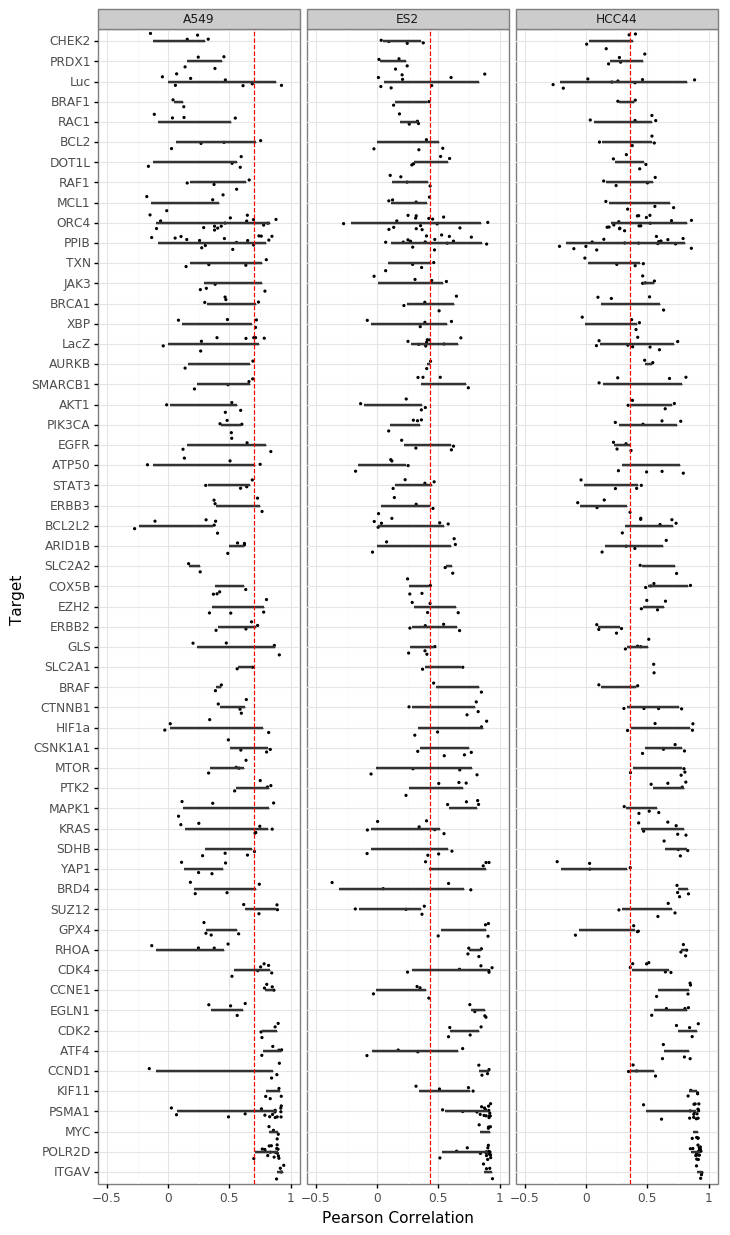

<ggplot: (-9223372036554128668)>

In [11]:
gg.options.figure_size=(8, 15)

gene_correlation_gg = (
    gg.ggplot(audit_df,
              gg.aes(x="correlation",
                     y="gene_plot_id")) + \
        gg.geom_jitter(size=0.3) + \
        gg.geom_boxplot() + \
        gg.xlab("Pearson Correlation") + \
        gg.ylab("Target") + \
        gg.geom_vline(gg.aes(xintercept="null_threshold"),
                      linetype='dashed',
                      color='red') + \
        gg.xlim([-0.5, 1]) + \
        gg.facet_grid("~Metadata_cell_line") + \
        gg.theme_bw()
)
    
gene_correlation_gg

In [12]:
file = os.path.join("figures", "target-guide-correlation")
for extension in ['.png', '.pdf']:
    gg.ggsave(gene_correlation_gg,
              filename='{}{}'.format(file, extension),
              dpi=300,
              height=15,
              width=8,
              units='in')

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 8 x 15 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/target-guide-correlation.png
  warn('Filename: {}'.format(filename))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.